<a href="https://colab.research.google.com/github/benj01/wp/blob/master/WP_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

## Imports

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd 

## Create soup object

In [ ]:
# Make the GET request to a url
r = requests.get('https://ssl.dropnet.ch/fws/directory/index_sc.php?language_code=de')
# Extract the content
c = r.content
# Create a soup object
soup = BeautifulSoup(c)

## Preparations

### Prepare XMLHttpRequest

In [ ]:
headers = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Origin': 'https://ssl.dropnet.ch',
    'Referer': 'https://ssl.dropnet.ch/',
    'Content-Length': '14',
    'Host': 'ssl.dropnet.ch',
    'Accept-Language': 'de-ch',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'X-Requested-With': 'XMLHttpRequest',
}

In [ ]:
headers2 = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Origin': 'https://ssl.dropnet.ch',
    'Referer': 'https://ssl.dropnet.ch/',
    'Content-Length': '15',
    'Host': 'ssl.dropnet.ch',
    'Accept-Language': 'de-ch',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'X-Requested-With': 'XMLHttpRequest',
}

### Create Dictionary with Producer Names

In [ ]:
# Find the element on the webpage
producer = soup.find(id='analysis_producer')
producer_dict = {}
for option in producer.find_all('option'):
    producer_dict[option['value']] = option.text
producer_dict.pop("-1")
producer_dict.pop("")

### Prepare Dataframe

In [ ]:
model_data = []
df = pd.DataFrame()

## Scrape Website (takes some time!)

In [ ]:
for models in producer_dict:
    model_data = BeautifulSoup(requests.post('https://ssl.dropnet.ch/fws/directory/json_api.php', headers=headers, data={'producer_id': models}).text)
    for model_now in model_data:
        model_options=model_now.select('option')
        for item in model_options:
            list_item = re.sub('\D', '', item.attrs['value'])
            list_items_data = BeautifulSoup(requests.post('https://ssl.dropnet.ch/fws/directory/json_api.php', headers=headers2, data={'heatpump_id': list_item}).text)
            split1 = list_items_data.getText().split('{')
            split2 = split1[2].split(',')
            value = []
            for splitnow in split2:
                value.append(splitnow.split(':')[1].strip('"}'))
            new_row = {'Name':producer_dict[models], 'Modell':item.text, 'A2':value[0], 'A7':value[1], 'ErP':value[2], 'Tag':value[3], 'Nacht':value[4]}
            df = df.append(new_row, ignore_index=True)

            #detail_list.append(BeautifulSoup(requests.post('https://ssl.dropnet.ch/fws/directory/json_api.php', headers=headers2, data={'heatpump_id': list_item}).text))
            #print(item.getText())

## Cleanup

In [ ]:
df['Tag']=pd.to_numeric(df['Tag'], errors='coerce')
df['Nacht']=pd.to_numeric(df['Nacht'], errors='coerce')
df['ErP']=pd.to_numeric(df['ErP'], errors='coerce')
df['A2']=pd.to_numeric(df['A2'], errors='coerce')
df['A7']=pd.to_numeric(df['A7'], errors='coerce')
df = df[['Name','Modell', 'A2', 'A7', 'ErP', 'Tag', 'Nacht']]
df = df.dropna(how='any',axis=0) 
df['Modell'] = df['Modell'].str.replace(r'"}','')

## Save Dataframe to disk

In [ ]:
from os.path import join
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
if not os.path.exists('/gdrive/My Drive/Colab Notebooks/WP-CAS/'):
    os.makedirs('/gdrive/My Drive/Colab Notebooks/WP-CAS/')
os.chdir('/gdrive/My Drive/Colab Notebooks/WP-CAS/')

In [ ]:
df.to_pickle("./WP_webscrape_sept2020.pkl")

# Read Dataframe from Disk

In [ ]:
import os
import pandas as pd
from os.path import join
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/Colab Notebooks/WP-CAS/')
df = pd.read_pickle("./WP_webscrape_sept2020.pkl")

Mounted at /gdrive


# Plotting

## Imports

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%load_ext google.colab.data_table

In [ ]:
!pip install -q ipympl
%matplotlib widget

     |████████████████████████████████| 2.0MB 2.8MB/s 


## Seaborn Visualization

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

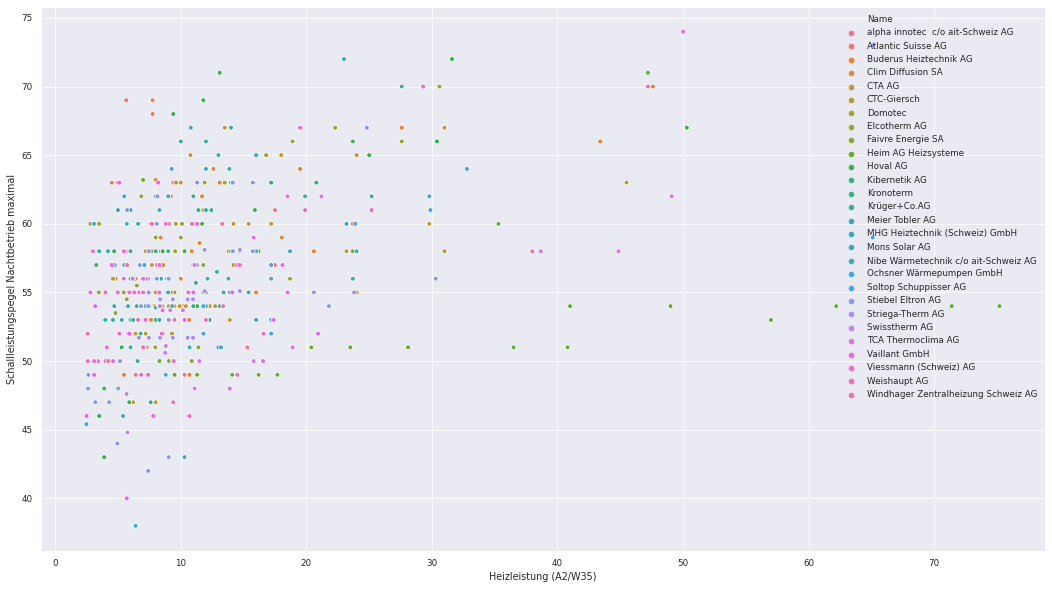

In [ ]:
sns.set()
sns.set_context("paper")
plt.figure(figsize=(18, 10))
ax=sns.scatterplot("A2", "Nacht", data=df, hue="Name")
ax.set(xlabel='Heizleistung (A2/W35)', ylabel='Schallleistungspegel Nachtbetrieb maximal')
plt.legend(loc='upper right')
plt.show()

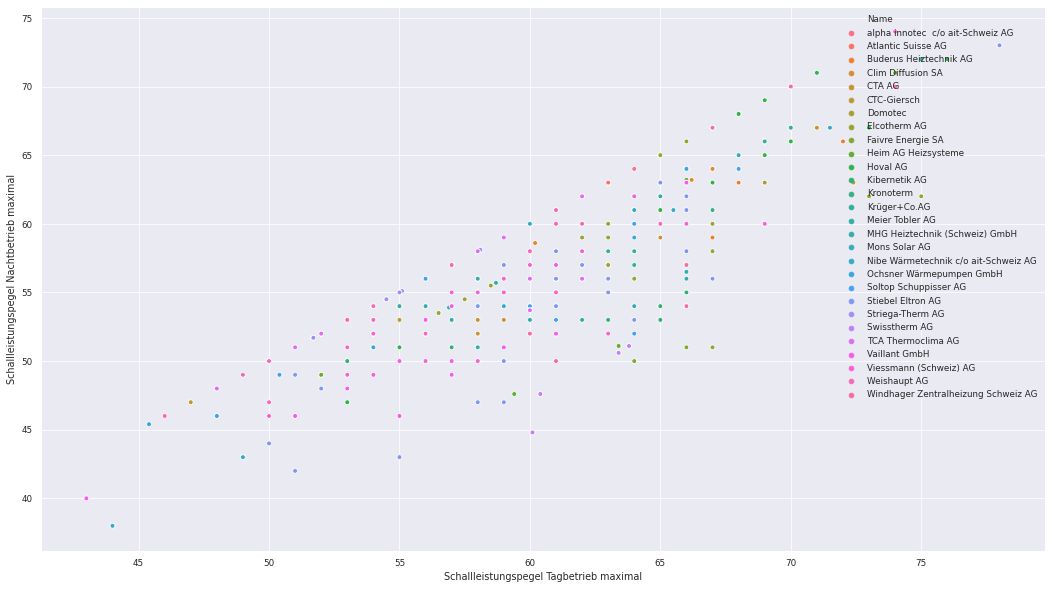

In [ ]:
sns.set()
sns.set_context("paper")
plt.figure(figsize=(18, 10))
ax=sns.scatterplot("Tag", "Nacht", data=df, hue="Name")
ax.set(xlabel='Schallleistungspegel Tagbetrieb maximal', ylabel='Schallleistungspegel Nachtbetrieb maximal')
plt.legend(loc='upper right')

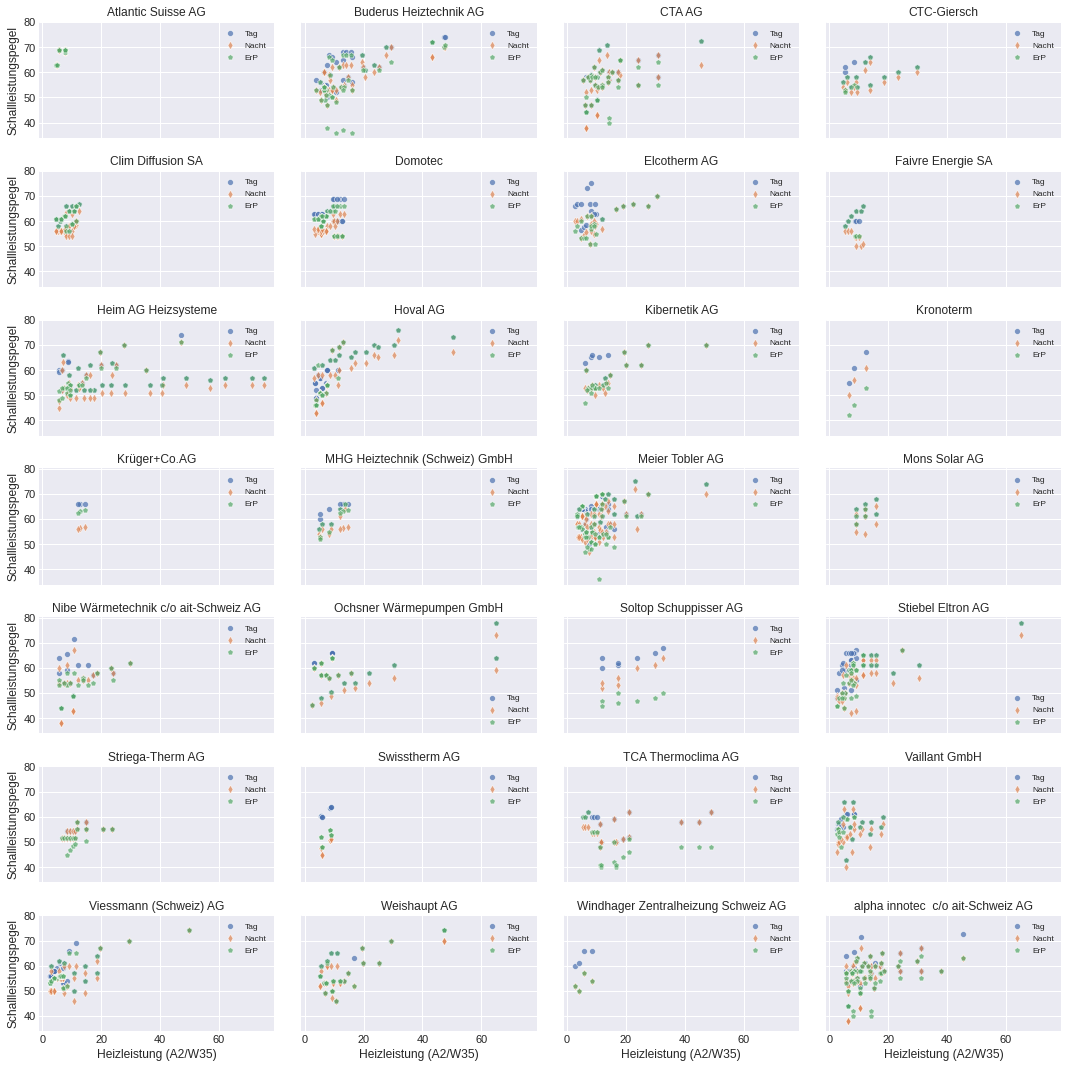

In [ ]:
hGroups = df.groupby('Name')
nameList = []
for name, group in hGroups:
    nameList.append(name)

sns.set()
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15,15), sharey=True,sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i == len(hGroups):
        break
    ax.set_title(nameList[i])
    sns.scatterplot("A2", "Tag", data=df.loc[df['Name'] == nameList[i]], ax=ax, label='Tag', marker='o', alpha=0.7)
    sns.scatterplot("A2", "Nacht", data=df.loc[df['Name'] == nameList[i]], ax=ax, label='Nacht', marker='d', alpha=0.7)
    sns.scatterplot("A2", "ErP", data=df.loc[df['Name'] == nameList[i]], ax=ax, label='ErP', marker='p', alpha=0.7)
    ax.set_xlabel('Heizleistung (A2/W35)')
    ax.set_ylabel('Schallleistungspegel')
    ax.legend(fontsize='x-small')
fig.tight_layout()

## Interactive Dataframe

https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
@interact
def show_articles_more_than(column=['Tag','Nacht','ErP'], x=(10,80,1)):
    return df.loc[df[column] > x]

interactive(children=(Dropdown(description='column', options=('Tag', 'Nacht', 'ErP'), value='Tag'), IntSlider(…

In [ ]:
@interact
def show_articles_less_than(column=['Tag','Nacht','ErP'], x=(10,80,1)):
    return df.loc[df[column] < x]

interactive(children=(Dropdown(description='column', options=('Tag', 'Nacht', 'ErP'), value='Tag'), IntSlider(…

https://plotly.com/python/ipython-notebook-tutorial/

https://colab.research.google.com/notebooks/snippets/altair.ipynb#scrollTo=0hphtO4Pp0hX

## Altair Visualization

In [ ]:
import altair as alt
alt.Chart(df).mark_point().encode(
  x='Tag',
  y='Nacht',
  color='Name',
  tooltip=['Name:N', 'Modell:N']
).interactive()

alt.Chart(...)

In [ ]:
import altair as alt

interval = alt.selection_interval()

points = alt.Chart(df).mark_point().encode(
  x='Nacht',
  y='A2',
  color=alt.condition(interval, 'Name', alt.value('lightgray'))
).properties(
  selection=interval, width=800
)

histogram = alt.Chart(df).mark_bar().encode(
  x='count()',
  y='Name',
  color='Name'
).properties(width=800
).transform_filter(interval)

points & histogram

alt.VConcatChart(...)

In [ ]:
import altair as alt

interval = alt.selection_interval()

points = alt.Chart(df).mark_point().encode(
  alt.X('Tag:Q',
  scale=alt.Scale(zero=False)
  ),
  alt.Y('Nacht:Q',
  scale=alt.Scale(zero=False)
  ),
  color=alt.condition(interval, 'Name', alt.value('lightgray'))
).properties(
  selection=interval, width=800
)

histogram = alt.Chart(df).mark_bar().encode(
  x='count()',
  y='Name',
  color='Name'
).properties(width=800
).transform_filter(interval)

points & histogram

alt.VConcatChart(...)

# Alt

### Scrapy

In [ ]:
# Settings for notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Show Python version
import platform
platform.python_version()

'3.6.9'

In [ ]:
try:
    import scrapy
except:
    !pip install -q scrapy
    import scrapy
from scrapy.crawler import CrawlerProcess

     |████████████████████████████████| 245kB 9.2MB/s 
     |████████████████████████████████| 2.6MB 28.4MB/s 
     |████████████████████████████████| 3.1MB 50.7MB/s 
     |████████████████████████████████| 3.2MB 49.1MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 235kB 55.4MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 51kB 877kB/s 


In [ ]:
import json

class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('quoteresult.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [ ]:
import logging

class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'http://quotes.toscrape.com/page/1/',
        'http://quotes.toscrape.com/page/2/',
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'quoteresult.json'                        # Used for pipeline 2
    }
    
    def parse(self, response):
        for quote in response.css('div.quote'):
            yield {
                'text': quote.css('span.text::text').extract_first(),
                'author': quote.css('span small::text').extract_first(),
                'tags': quote.css('div.tags a.tag::text').extract(),
            }

In [ ]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(QuotesSpider)
process.start()

In [ ]:
import pandas as pd
dfjson = pd.read_json('quoteresult.json')
dfjson

In [ ]:
dfjl = pd.read_json('quoteresult.jl', lines=True)
dfjl

In [ ]:
dfjson.to_pickle('quotejson.pickle')
dfjl.to_pickle('quotejl.pickle')

In [ ]:
ll *pickle

-rw-r--r-- 1 root 5491 Sep  9 14:32 quotejl.pickle
-rw-r--r-- 1 root 5491 Sep  9 14:32 quotejson.pickle


https://botproxy.net/docs/how-to/how-to-simulate-xhr-request-using-scrapy-when-trying-to-crawl-data-from-an-ajax-based-/

In [ ]:
class googleAppSpider(Spider):
    name = "googleApp"
    allowed_domains = ['play.google.com']
    start_urls = ['https://play.google.com/store/apps/category/GAME/collection/topselling_new_free?authuser=0']

    def parse(self,response):
        for i in range(0,10): 
            yield FormRequest(url="https://play.google.com/store/apps/category/GAME/collection/topselling_new_free?authuser=0", method="POST", formdata={'start':str(i*60),'num':'60','numChildren':'0','ipf':'1','xhr':'1','token':'m1VdlomIcpZYfkJT5dktVuqLw2k:1455483261011'}, callback=self.data_parse)

    def data_parse(self,response):
        item = googleAppItem()
        map = {}
        links = response.xpath("//a/@href").re(r'/store/apps/details.*')
        for l in links:
            if l not in map:
                map[l] = True
                item['url'] = l
                yield item

In [ ]:
import scrapy


class ZapposMenShoesSpider(scrapy.Spider):
    name = "zappos_p"
    start_urls = ['https://www.zappos.com/men-running-shoes']
    allowed_domains = ['www.zappos.com']


    def parse(self, response):
        for product in response.css("article"):
            yield {
                "name": product.css("p[itemprop='name']::text").extract_first(),
                "by": product.css("p[itemprop='brand'] span[itemprop='name']::text").extract_first(),
                "price": product.css("p span::text").extract()[1],
                "stars": product.css(
                    "p span[itemprop='aggregateRating']::attr('data-star-rating')"
                ).extract_first(),
                "img-url": product.css(
                    "div span img::attr('src')").extract_first()
            }


        next_url_path = response.css(
            "a[rel='next']::attr('href')").extract_first()
        if next_url_path:
            yield scrapy.Request(
                response.urljoin(next_url_path),
                callback=self.parse
            )

### Selenium

https://www.pluralsight.com/guides/advanced-web-scraping-tactics-python-playbook

In [ ]:
# pluralsight.py
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException


def configure_driver():
    # Add additional Options to the webdriver
    chrome_options = Options()
    # add the argument and make the browser Headless.
    chrome_options.add_argument("--headless")
    # Instantiate the Webdriver: Mention the executable path of the webdriver you have downloaded
    # For linux/Mac
    # driver = webdriver.Chrome(options = chrome_options)
    # For windows
    driver = webdriver.Chrome(executable_path="./chromedriver.exe", options = chrome_options)
    return driver


def getCourses(driver, search_keyword):
    # Step 1: Go to pluralsight.com, category section with selected search keyword
    driver.get(f"https://www.pluralsight.com/search?q={search_keyword}&categories=course")
    # wait for the element to load
    try:
        WebDriverWait(driver, 5).until(lambda s: s.find_element_by_id("search-results-category-target").is_displayed())
    except TimeoutException:
        print("TimeoutException: Element not found")
        return None

    # Step 2: Create a parse tree of page sources after searching
    soup = BeautifulSoup(driver.page_source, "lxml")
    # Step 3: Iterate over the search result and fetch the course
    for course_page in soup.select("div.search-results-page"):
        for course in course_page.select("div.search-result"):
            title_selector = "div.search-result__info div.search-result__title a"
            author_selector = "div.search-result__details div.search-result__author"
            level_selector = "div.search-result__details div.search-result__level"
            length_selector = "div.search-result__details div.search-result__length"
            print({
                "title": course.select_one(title_selector).text,
                "author": course.select_one(author_selector).text,
                "level": course.select_one(level_selector).text,
                "length": course.select_one(length_selector).text,
            })

# create the driver object.
driver = configure_driver()
search_keyword = "Web Scraping"
getCourses(driver, search_keyword)
# close the driver.
driver.close()

### Eigene Versuche

In [ ]:
import scrapy


class mySpider(scrapy.Spider):
    name = "myspider"
    start_urls = ['https://ssl.dropnet.ch/fws/directory/index_sc.php?language_code=de']
    allowed_domains = ['https://ssl.dropnet.ch']


    def parse(self, response):
        for product in response.css("#analysis_producer"):
            yield {
                "name": product.css("p[itemprop='name']::text").extract_first(),
                "by": product.css("p[itemprop='brand'] span[itemprop='name']::text").extract_first(),
                "price": product.css("p span::text").extract()[1],
                "stars": product.css(
                    "p span[itemprop='aggregateRating']::attr('data-star-rating')"
                ).extract_first(),
                "img-url": product.css(
                    "div span img::attr('src')").extract_first()
            }


        next_url_path = response.css(
            "a[rel='next']::attr('href')").extract_first()
        if next_url_path:
            yield scrapy.Request(
                response.urljoin(next_url_path),
                callback=self.parse
            )

In [ ]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(mySpider)
process.start()

In [ ]:
process.

In [ ]:
mySpider.parse.response()

In [ ]:
!scrapy shell 'https://ssl.dropnet.ch/fws/directory/index_sc.php?language_code=de'

In [ ]:
import requests

headers = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Origin': 'https://ssl.dropnet.ch',
    'Referer': 'https://ssl.dropnet.ch/',
    'Content-Length': '14',
    'Host': 'ssl.dropnet.ch',
    'Accept-Language': 'de-ch',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'X-Requested-With': 'XMLHttpRequest',
}

data = {
  'producer_id': '44'
}

response = requests.post('https://ssl.dropnet.ch/fws/directory/json_api.php', headers=headers, data=data)

In [ ]:
response.text

'{"status":"success","html":"<option value=\'\' selected>Bitte ausw\\u00e4hlen<\\/option><option value=\\"768\\">Kronoterm, ADAPT 0312 K3 HT \\/ HK 3F<\\/option><option value=\\"769\\">Kronoterm, ADAPT 0416 K3 HT \\/ HK 3F<\\/option><option value=\\"770\\">Kronoterm, ADAPT 0724 K3 HT \\/ HK 3F<\\/option>"}'